# Investigating which areas show significant second level effects at which times

In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import source_visualisations as sv
import source_statistics as ss
import mne

## Data preparation
Which data?

In [2]:
# baseline [-0.3, 0], trialregs_dot=5
# basefile = 'source_HCPMMP1_allsubs_201703301614.h5'

# baseline None, trialregs_dot=5
#basefile = 'source_HCPMMP1_allsubs_201706091054.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space
#basefile = 'source_sequential_201706141650.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, sum_dot_y
#basefile = 'source_sequential_201706191442.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706201654.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706261151.h5'

# label mode = (abs)max, baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, GLM in source space, 
# move_dist, sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706281100.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, move_dist, 
# sum_dot_y, constregs=0 for 1st dot, 
# label_tc normalised across trials, times and subjects
#basefile = 'source_sequential_201707031206.h5'

# label mode = mean, baseline (-0.3, 0), only first 3 dots, 
# trialregs_dot=3, source GLM, move_dist, sum_dot_y, constregs=0 for 1st dot, 
# label_tc normalised across trials, times and subjects
#basefile = 'source_sequential_201708241011.h5'

# label mode = mean, baseline (-0.3, 0), only first 3 dots, 
# trialregs_dot=0, source GLM, sum_dot_y, motoprep, constregs=0 for 1st dot, 
# subject-specific normalisation of DM without centering and scaling by std
# label_tc normalised across trials, times and subjects
#basefile = 'source_sequential_201709011758.h5'

# label mode = mean, baseline (-0.3, 0), first 5 dots, 
# trialregs_dot=0, source GLM, sum_dot_y, constregs=0 for 1st dot, 
# subject-specific normalisation of DM without centering and scaling by std
# label_tc normalised across trials, times and subjects
basefile = 'source_sequential_201709061827.h5'

# label mode = mean, baseline (-0.3, 0), dots 3-5, 
# source GLM, sum_dot_y_prev_3, accev_3, dot_x, dot_y, trial regressors
# subject-specific normalisation of DM without centering and scaling by std
# label_tc normalised across trials, times and subjects
#basefile = 'source_singledot_201709071126.h5.tmp'

choose measure and identify threshold

In [3]:
# e.g.: mu_p_large, mu_testval, mu_t, mu_mean
#measure = 'mu_mean'
measure = 'mu_mean'
if measure in ['mean', 'std', 'tval', 'mlog10p']:
    use_basefile = True
else:
    use_basefile = False

# which regressors should define the empirical value distribution?
# set regressors = None for all
regressors = ['accev', 'dot_x', 'dot_y', 'abs_dot_x', 'abs_dot_y', 'sum_dot_y_prev']
#regressors = ['motoprep', 'response', 'trial_time', 'entropy']
#regressors = ['accev_3', 'dot_x_3', 'dot_x_4', 'dot_x_5', 'dot_y_3', 'dot_y_4',
#              'dot_y_5', 'entropy', 'response', 'sum_dot_y_prev_3',
#              'trial_time']

# do not use these regressors to define empirical value distribution
#exclude = 'trialregs'
#exclude = 'dotregs'

# the empiric error threshold for a single time point and area
# (the selected threshold will be the quantile 1-alpha of the 
# empirical distribution of measure values)
alpha = 0.05

threshold, measure_cdf = ss.find_slabs_threshold(
    basefile, measure, quantile=1-alpha, regressors=regressors, 
    verbose=1, return_cdf=True, use_basefile=use_basefile)

print('\nthreshold = {:.4f}'.format(threshold))

adding accev
adding dot_x
adding dot_y
adding abs_dot_x
adding abs_dot_y
adding sum_dot_y_prev
N = 108600

threshold = 0.0180


what are large values for the possible measures (used for setting y-lim in plotting)

In [4]:
ylims = {'mu_p_large': 1, 'mu_t': 8, 'mu_z': 8, 'mu_testval': 0.02, 'mu_mean': 0.04,
         'tval': 7, 'mlog10p': 7, 'mean': 0.07}
logy = {'mu_p_large': False, 'mu_t': False, 'mu_z': False, 'mu_testval': True, 'mu_mean': False,
        'tval': False, 'mean':False, 'mlog10p': False}

## Load data for all selected regressors and identify significant clusters in time
The idea is that you identify sequences of high measure values that cannot happen by chance. This is all based on the empirical measure distribution used above. This distribution defines the probability with which I would get a particular measure value, if I were to draw one randomly across locations, time points and regressors. So it is a permutation distribution. I then use the cumulative density function of this distribution to first select a cluster threshold, i.e., a measure value which has to be exceeded in order to form a sequence cluster. Then I identify clusters, i.e., sequences of measure values within an area that exceed the threshold. The p-value of the found cluster is the product of 1-cdf(value) for the measure values in the sequence.

In [5]:
clusters = ss.get_fdrcorr_clusters(basefile, regressors, measure, threshold, measure_cdf,
                                   fdr_alpha=0.001, use_basefile=use_basefile)

print('cluster counts:')
print(clusters.label.groupby(level='regressor').count())

clusters.sort_values('start_t').sort_index(level='regressor', sort_remaining=False)

cluster counts:
regressor
accev             219
dot_x             170
dot_y              25
abs_dot_x          15
abs_dot_y           7
sum_dot_y_prev     35
Name: label, dtype: int64


label  start_t  end_t      log10p  \
regressor      cluster                                               
accev          499        R_PCV_ROI-rh        0     40   -7.089084   
               594      R_TPOJ3_ROI-rh        0     20   -4.472587   
               367        R_5mv_ROI-rh        0     40   -7.875264   
               252        L_V3B_ROI-lh        0     50  -10.125189   
               242         L_V1_ROI-lh       10     30   -7.262291   
               425        R_AIP_ROI-rh       10     50   -7.219310   
               169        L_PCV_ROI-lh       10     30   -4.388474   
               331       R_31pd_ROI-rh       10    380  -81.717344   
               480        R_MIP_ROI-rh       10     40   -6.794242   
               597         R_V1_ROI-rh       10     30   -6.331878   
               537       R_POS1_ROI-rh       10     30   -4.859575   
               613        R_V3B_ROI-rh       10     30   -4.760928   
               631         R_V6_ROI-rh       20    490 -106.313817   
               652      R_d23ab_ROI-rh       30    310  -51.610729   
               340         R_3a_ROI-rh       30     60   -6.224330   
               353          R_4_ROI-rh       30     60   -6.471204   
               632         R_V7_ROI-rh       30    160  -31.975850   
               41        L_31pd_ROI-lh       30    380  -73.615817   
               391         R_7m_ROI-rh       30    390  -82.779925   
               99          L_7m_ROI-lh       30    380  -76.286569   
               621         R_V3_ROI-rh       30     90  -10.669886   
               43        L_31pv_ROI-lh       30    380  -69.629146   
               286      L_d23ab_ROI-lh       30    310  -55.555735   
               539        R_PSL_ROI-rh       40     60   -4.670056   
               432        R_DVT_ROI-rh       40    150  -22.737128   
               333       R_31pv_ROI-rh       40    380  -62.162205   
               452        R_IP0_ROI-rh       40    130  -18.279179   
               460       R_IPS1_ROI-rh       40    110  -13.777290   
               301      L_v23ab_ROI-lh       40    450 -101.847776   
               525        R_PGp_ROI-rh       40    140  -18.196688   
...                                ...      ...    ...         ...   
sum_dot_y_prev 294        R_PGp_ROI-rh       50     80   -7.657872   
               269       R_IPS1_ROI-rh       50     90   -9.243031   
               334        R_V6A_ROI-rh       60     90   -6.336470   
               303       R_POS2_ROI-rh       60     90   -6.613918   
               300       R_POS1_ROI-rh       60     80   -5.234047   
               107       L_POS1_ROI-lh       60     80   -4.515746   
               45          L_A5_ROI-lh       60     80   -4.467734   
               337         R_V6_ROI-rh       80    100   -4.517447   
               246        R_DVT_ROI-rh      150    180   -5.839113   
               342         R_V7_ROI-rh      150    180   -5.974627   
               263        R_IP0_ROI-rh      150    180   -6.260625   
               314      R_STSvp_ROI-rh      150    170   -4.738329   
               218         R_43_ROI-rh      160    180   -4.417499   
               47          L_A5_ROI-lh      160    180   -4.412459   
               121      L_STSdp_ROI-lh      210    230   -4.575528   
               25         L_7AL_ROI-lh      210    230   -4.428656   
               351       R_a47r_ROI-rh      220    240   -4.409208   
               252          R_H_ROI-rh      230    260   -6.099372   
               338         R_V6_ROI-rh      240    280   -8.397218   
               89         L_OP4_ROI-lh      250    280   -5.805624   
               221        R_47m_ROI-rh      270    290   -4.738587   
               122      L_STSdp_ROI-lh      280    300   -4.472831   
               40          L_8C_ROI-lh      300    340   -7.089285   
               265        R_IP0_ROI-rh      350    370   -4.357357   
               257       R_IFSa_ROI-rh     

## Find all clusters of a given area or region

In [7]:
area = 'v23ab'
clusters[clusters.label.apply(lambda s: s.find(area) >= 0)]

label  start_t  end_t     log10p  pval_corrected  \
regressor cluster                                                              
accev_3   662      L_v23ab_ROI-lh      160    190  -7.609664    3.511928e-07   
          663      L_v23ab_ROI-lh      250    280  -7.100824    9.958746e-07   
          664      L_v23ab_ROI-lh      300    540 -63.445864    2.559538e-61   
          665      L_v23ab_ROI-lh      560    640 -15.816961    8.231511e-15   
          1264     R_v23ab_ROI-rh      150    190  -7.960137    1.680193e-07   
          1265     R_v23ab_ROI-rh      240    640 -95.189009    1.001864e-92   
dot_x_3   462      L_v23ab_ROI-lh      310    330  -5.826510    1.347304e-05   
          463      L_v23ab_ROI-lh      360    400 -11.032295    2.637095e-10   
          464      L_v23ab_ROI-lh      510    710 -50.737029    7.736010e-49   
          465      L_v23ab_ROI-lh      730    760  -7.091880    1.014544e-06   
          1008     R_v23ab_ROI-rh      310    330  -5.531006    2.508771e-05   
          1009     R_v23ab_ROI-rh      370    400  -7.862174    2.077911e-07   
          1010     R_v23ab_ROI-rh      520    690 -42.886026    4.025518e-41   
          1012     R_v23ab_ROI-rh      750    760  -3.854465    6.918947e-04   
dot_x_4   478      L_v23ab_ROI-lh      400    430 -10.161385    1.690225e-09   
          481      L_v23ab_ROI-lh      680    730 -12.973898    4.009922e-12   
          1116     R_v23ab_ROI-rh      400    430  -8.535643    5.086442e-08   
          1118     R_v23ab_ROI-rh      480    500  -4.250577    3.103303e-04   
          1121     R_v23ab_ROI-rh      680    730 -14.162654    3.012861e-13   
          1122     R_v23ab_ROI-rh      750    770  -4.360809    2.496762e-04   
dot_x_5   470      L_v23ab_ROI-lh      540    620 -19.483383    2.725007e-18   
          471      L_v23ab_ROI-lh      690    890 -48.159302    2.515448e-46   
          935      R_v23ab_ROI-rh      540    620 -17.732398    1.264828e-16   
          936      R_v23ab_ROI-rh      690    890 -51.813130    6.801732e-50   
dot_y_3   766      R_v23ab_ROI-rh       80    100  -4.827318    1.003260e-04   
dot_y_4   316      L_v23ab_ROI-lh       20     40  -5.707612    1.736128e-05   
          716      R_v23ab_ROI-rh       20     40  -6.701286    2.277443e-06   
response  380      L_v23ab_ROI-lh      440    460  -6.203503    6.281743e-06   
          742      R_v23ab_ROI-rh      440    460  -6.725806    2.164163e-06   
          743      R_v23ab_ROI-rh      610    620  -3.990586    5.282441e-04   

                                       region  
regressor cluster                              
accev_3   662      posterior cingulate cortex  
          663      posterior cingulate cortex  
          664      posterior cingulate cortex  
          665      posterior cingulate cortex  
          1264     posterior cingulate cortex  
          1265     posterior cingulate cortex  
dot_x_3   462      posterior cingulate cortex  
          463      posterior cingulate cortex  
          464      posterior cingulate cortex  
          465      posterior cingulate cortex  
          1008     posterior cingulate cortex  
          1009     posterior cingulate cortex  
          1010     posterior cingulate cortex  
          1012     posterior cingulate cortex  
dot_x_4   478      posterior cingulate cortex  
          481      posterior cingulate cortex  
          1116     posterior cingulate cortex  
          1118     posterior cingulate cortex  
          1121     posterior cingulate cortex  
          1122     posterior cingulate cortex  
dot_x_5   470      posterior cingulate cortex  
          471      posterior cingulate cortex  
          935      posterior cingulate cortex  
          936      posterior cingulate cortex  
dot_y_3   766      posterior cingulate cortex  
dot_y_4   316      posterior cingulate cortex  
          716      posterior cingulate cortex  
response  380      posterior cingulate cortex  
          742      posterio

In [8]:
region = 'dorso'
clusters[clusters.region.apply(lambda s: s.find(region) >= 0)]

label  start_t  end_t     log10p  \
regressor      cluster                                             
accev          100       L_8Ad_ROI-lh      220    290 -12.093534   
               223       L_SFL_ROI-lh      370    380  -3.860986   
               402        R_9a_ROI-rh      170    200  -6.453679   
               681      R_s6-8_ROI-rh      350    400  -9.617252   
dot_x          386      R_s6-8_ROI-rh      450    470  -4.063197   
sum_dot_y_prev 40         L_8C_ROI-lh      300    340  -7.089285   

                        pval_corrected                          region  
regressor      cluster                                                  
accev          100        9.637287e-12  dorsolateral prefrontal cortex  
               223        5.299177e-04  dorsolateral prefrontal cortex  
               402        2.256008e-06  dorsolateral prefrontal cortex  
               681        2.278109e-09  dorsolateral prefrontal cortex  
dot_x          386        3.369966e-04  dorsolateral prefrontal cortex  
sum_dot_y_prev 40         5.660779e-07  dorsolateral prefrontal cortex

## Investigate individual regressors

In [21]:
r_name = 'dot_x'
#r_name = 'trial_time'
r_clusters = clusters.xs(r_name, level='regressor').copy()

src_df = ss.load_src_df(basefile, r_name, use_basefile=use_basefile)

### Check the times at which we see significant clusters

<IPython.core.display.Javascript object>


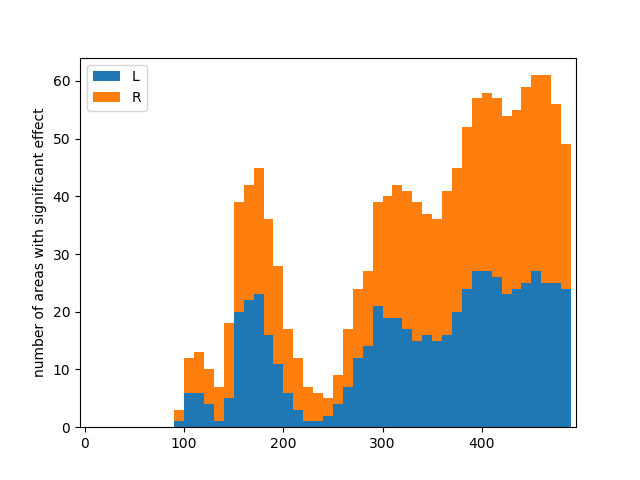

In [22]:
times = src_df[measure].index.levels[1]
sigareas = r_clusters.label.unique()
significant = pd.DataFrame(np.zeros((sigareas.size, times.size), bool), 
                           index=sigareas, columns=times)
for row in r_clusters.itertuples():
    significant.loc[row.label, slice(row.start_t, row.end_t)] = True
    
fig, ax = plt.subplots()
left = significant.columns - 5
colors = plt.rcParams['axes.prop_cycle']._left

# plot left hemi 
numlh = significant[significant.index.map(lambda l: l[0]) == 'L'].sum()
ax.bar(left, height=numlh, width=10, bottom=0, color=colors[0]['color'])
# plot right hemi
ax.bar(left, 
       height=significant[significant.index.map(lambda l: l[0]) == 'R'].sum(), 
       width=10, bottom=numlh, color=colors[1]['color'])
ax.set_ylabel('number of areas with significant effect');
ax.legend(['L', 'R']);
ax.set_xlim(left[0], left[-1]+10);

### Count number of time points at which areas are in significant cluster

In [23]:
atmp = significant.sum(axis=1).sort_values(ascending=False)
atmp = pd.concat([atmp, pd.Series(list(map(ss.get_Glasser_section, atmp.index)), index=atmp.index)], 
                 axis=1, keys=['count', 'region'])
print(atmp.head(20))
del atmp

                count                          region
R_V6_ROI-rh        33     dorsal stream visual cortex
R_v23ab_ROI-rh     30      posterior cingulate cortex
L_v23ab_ROI-lh     30      posterior cingulate cortex
R_V7_ROI-rh        29     dorsal stream visual cortex
L_7m_ROI-lh        27      posterior cingulate cortex
R_PCV_ROI-rh       26      posterior cingulate cortex
R_DVT_ROI-rh       26      posterior cingulate cortex
L_31pd_ROI-lh      25      posterior cingulate cortex
L_LIPd_ROI-lh      25        superior parietal cortex
L_PCV_ROI-lh       25      posterior cingulate cortex
L_d23ab_ROI-lh     23      posterior cingulate cortex
R_7m_ROI-rh        23      posterior cingulate cortex
R_31pd_ROI-rh      22      posterior cingulate cortex
R_31pv_ROI-rh      22      posterior cingulate cortex
R_d23ab_ROI-rh     22      posterior cingulate cortex
R_4_ROI-rh         21  somatosensory and motor cortex
R_3b_ROI-rh        21  somatosensory and motor cortex
R_3a_ROI-rh        20  somat

### Identify areas

In [18]:
def get_areas(times):
    if type(times) is not list:
        times = [times]
    
    return significant[np.all(significant[times], axis=1)].index

def active_areas(times, times2=None):
    """Returns areas that are reliably activated at all time points in times.
       If times2 is provided, intersection and set differences of areas 
       associated with times and times2 are indicated."""
    
    print(r_name)
    
    areas = get_areas(times)
    
    if times2 is None:
        areas2 = pd.Index([])
    else:
        areas2 = get_areas(times2)
    
    areas = pd.concat([pd.Series(areas.difference(areas2)), 
                       pd.Series(areas.intersection(areas2)), 
                       pd.Series(areas2.difference(areas))],
                      keys=['only 1', 'intersect', 'only 2'])
    areas = pd.DataFrame(areas, columns=['area'])
    
    areas['region'] = areas.area.apply(ss.get_Glasser_section)
    
    return areas

In [19]:
active_areas(20, 150)

accev


area                                           region
only 1    0      L_V1_ROI-lh                            primary visual cortex
          1    R_POS1_ROI-rh                       posterior cingulate cortex
          2   R_TPOJ3_ROI-rh               temporo-parieto-occipital junction
          3      R_V1_ROI-rh                            primary visual cortex
intersect 0     L_PCV_ROI-lh                       posterior cingulate cortex
          1     L_V3B_ROI-lh                      dorsal stream visual cortex
          2    R_31pd_ROI-rh                       posterior cingulate cortex
          3     R_5mv_ROI-rh     paracentral lobular and mid cingulate cortex
          4     R_AIP_ROI-rh                         superior parietal cortex
          5     R_MIP_ROI-rh                         superior parietal cortex
          6     R_PCV_ROI-rh                       posterior cingulate cortex
          7     R_V3B_ROI-rh                      dorsal stream visual cortex
          8      R_V6_ROI-rh                      dorsal stream visual cortex
only 2    0    L_31pd_ROI-lh                       posterior cingulate cortex
          1    L_31pv_ROI-lh                       posterior cingulate cortex
          2    L_33pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          3      L_3a_ROI-lh                   somatosensory and motor cortex
          4      L_3b_ROI-lh                   somatosensory and motor cortex
          5       L_4_ROI-lh                   somatosensory and motor cortex
          6      L_7m_ROI-lh                       posterior cingulate cortex
          7     L_DVT_ROI-lh                       posterior cingulate cortex
          8    L_LIPd_ROI-lh                         superior parietal cortex
          9     L_MST_ROI-lh         MT+ complex and neighboring visual areas
          10   L_V3CD_ROI-lh         MT+ complex and neighboring visual areas
          11     L_V6_ROI-lh                      dorsal stream visual cortex
          12  L_d23ab_ROI-lh                       posterior cingulate cortex
          13  L_v23ab_ROI-lh                       posterior cingulate cortex
          14   R_24dv_ROI-rh     paracentral lobular and mid cingulate cortex
          15    R_31a_ROI-rh                       posterior cingulate cortex
          16   R_31pv_ROI-rh                       posterior cingulate cortex
          17     R_3a_ROI-rh                   somatosensory and motor cortex
          18      R_4_ROI-rh                   somatosensory and motor cortex
          19     R_52_ROI-rh             insular and frontal opercular cortex
          20     R_6r_ROI-rh                                  premotor cortex
          21     R_7m_ROI-rh                       posterior cingulate cortex
          22     R_A1_ROI-rh                            early auditory cortex
          23    R_DVT_ROI-rh                       posterior cingulate cortex
          24  R_OP2-3_ROI-rh                       posterior opercular cortex
          25    R_PSL_ROI-rh               temporo-parieto-occipital junction
          26     R_V2_ROI-rh                              early visual cortex
          27    R_V3A_ROI-rh                      dorsal stream visual cortex
          28   R_V3CD_ROI-rh         MT+ complex and neighboring visual areas
          29     R_V7_ROI-rh                      dorsal stream visual cortex
          30  R_a24pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          31  R_d23ab_ROI-rh                       posterior cingulate cortex
          32  R_p24pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          33  R_v23ab_ROI-rh                       posterior cingulate cortex

In [13]:
active_areas(550)

response


area                                           region
only 1 0   L_24dd_ROI-lh     paracentral lobular and mid cingulate cortex
       1   L_24dv_ROI-lh     paracentral lobular and mid cingulate cortex
       2     L_3a_ROI-lh                   somatosensory and motor cortex
       3   L_SCEF_ROI-lh     paracentral lobular and mid cingulate cortex
       4   L_V3CD_ROI-lh         MT+ complex and neighboring visual areas
       5    L_VVC_ROI-lh                     ventral stream visual cortex
       6   R_24dv_ROI-rh     paracentral lobular and mid cingulate cortex
       7  R_p24pr_ROI-rh  anterior cingulate and medial prefrontal cortex

In [91]:
aa = active_areas(200)
df = pd.concat([aa.area.apply(lambda s: s[0]), aa.area.apply(lambda s: s[2:-7])],
               axis=1, keys=['hemi', 'area'])

lh = df[df.hemi == 'L'].area
rh = df[df.hemi == 'R'].area

print('\nonly L:')
print(', '.join(np.setdiff1d(lh.values, rh.values)))

print('\nonly R:')
print(', '.join(np.setdiff1d(rh.values, lh.values)))

print('\ncommon:')
print(', '.join(np.intersect1d(rh.values, lh.values)))

abs_dot_y

only L:
31pd, 31pv, 7m, d23ab

only R:
PHA1, VVC, v23ab

common:
23d


In [14]:
aa = active_areas(170, 320)
print('\nonly 1:')
print(aa.loc['only 1'])
print('\nintersect:')
print(aa.loc['intersect'])
print('\nonly 2:')
print(aa.loc['only 2'])

dot_x

only 1:
             area                                        region
0    L_23c_ROI-lh                    posterior cingulate cortex
1      L_2_ROI-lh                somatosensory and motor cortex
2    L_31a_ROI-lh                    posterior cingulate cortex
3     L_5L_ROI-lh  paracentral lobular and mid cingulate cortex
4    L_5mv_ROI-lh  paracentral lobular and mid cingulate cortex
5    L_DVT_ROI-lh                    posterior cingulate cortex
6    L_IP0_ROI-lh                      inferior parietal cortex
7   L_IPS1_ROI-lh                   dorsal stream visual cortex
8    L_MIP_ROI-lh                      superior parietal cortex
9   L_POS2_ROI-lh                    posterior cingulate cortex
10  L_ProS_ROI-lh                    posterior cingulate cortex
11   L_RSC_ROI-lh                    posterior cingulate cortex
12   L_V3A_ROI-lh                   dorsal stream visual cortex
13   L_V6A_ROI-lh                   dorsal stream visual cortex
14    L_V7_ROI-lh        

In [ ]:
active_areas(490, 600)

In [ ]:
active_areas(580, 650)

### Show significant clusters

In [24]:
def get_cluster_tcs(clus, baseval=0):

    mask = pd.Series(np.zeros_like(src_df[measure], dtype=bool), index=src_df[measure].index)
    for row in clus.itertuples():
        mask.loc[row.label, slice(row.start_t, row.end_t)] = True

    active = src_df[measure].where(mask, other=baseval)
    active = active.reset_index('label')
    active = active.pivot(columns='label')[measure]

    # get labels of active areas in given clusters
    maxvals = active.max()
    labels = maxvals.index[maxvals > baseval]

    # select only active areas
    active = active[labels]

    # get hemisphere of labels
    hemis = labels.map(lambda l: l[-2].upper())
    labels = labels.map(lambda l: l[2:-7])

    active.columns = pd.MultiIndex.from_arrays([hemis, labels],
                                               names=['hemi', 'label'])

    return active

### clusters from a particular region

In [1]:
print(r_name)

region = 'dorso'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.region.apply(lambda s: s.startswith(region))]), 
                    [threshold, ylims[measure]], logy=logy[measure])

NameError: name 'r_name' is not defined

### clusters associated with a particular area

dot_x


<IPython.core.display.Javascript object>


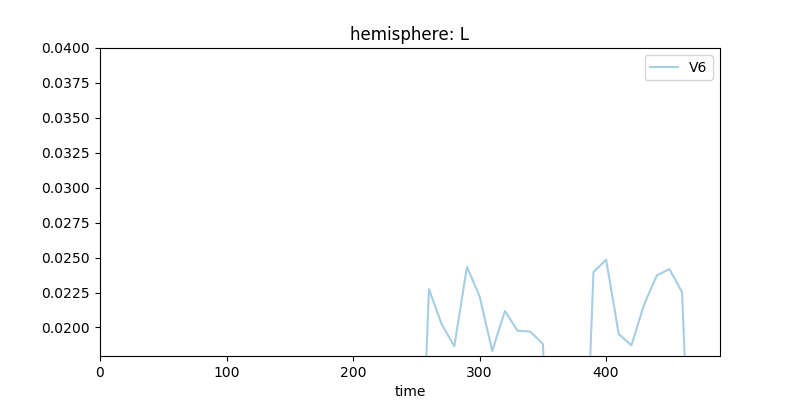

<IPython.core.display.Javascript object>


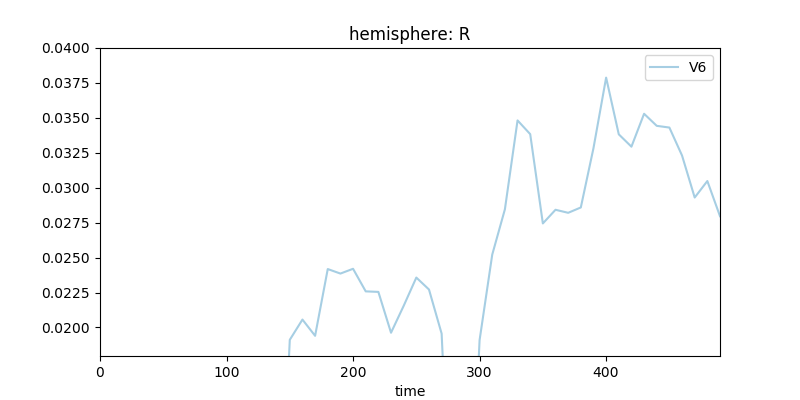

In [25]:
print(r_name)

# put the full area name in underscores such as '_1_' to match exactly
area = '_V6_'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.label.apply(lambda s: s.find(area)>0)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

accev


<IPython.core.display.Javascript object>


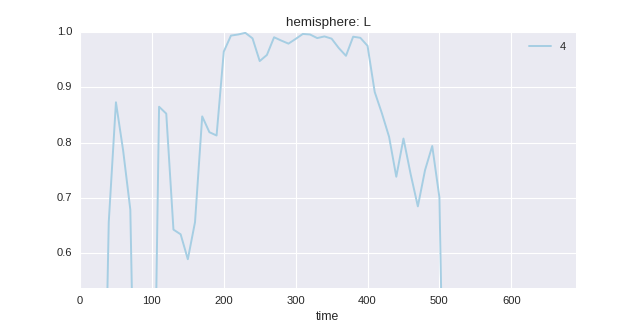

<IPython.core.display.Javascript object>


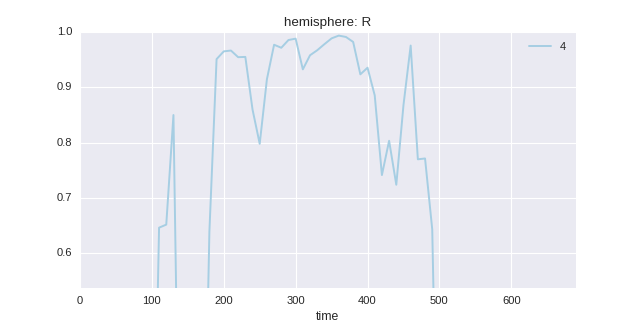

In [66]:
print(r_name)

# put the full area name in underscores such as '_1_' to match exactly
area = '_4_'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.label.apply(lambda s: s.find(area)>0)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters with reliable effect around a particular time

dot_x


<IPython.core.display.Javascript object>


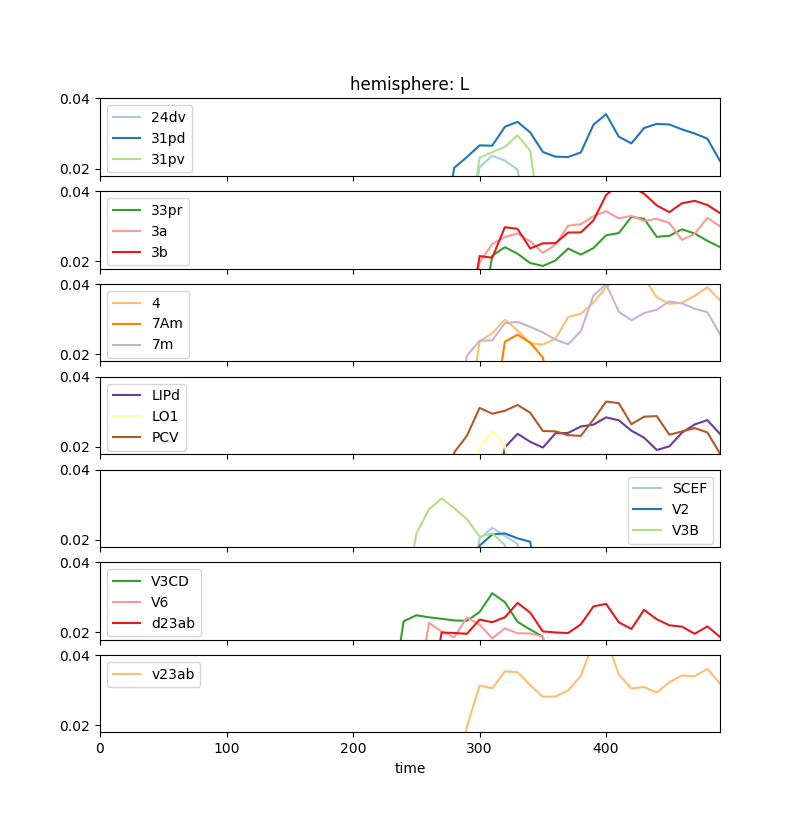

<IPython.core.display.Javascript object>


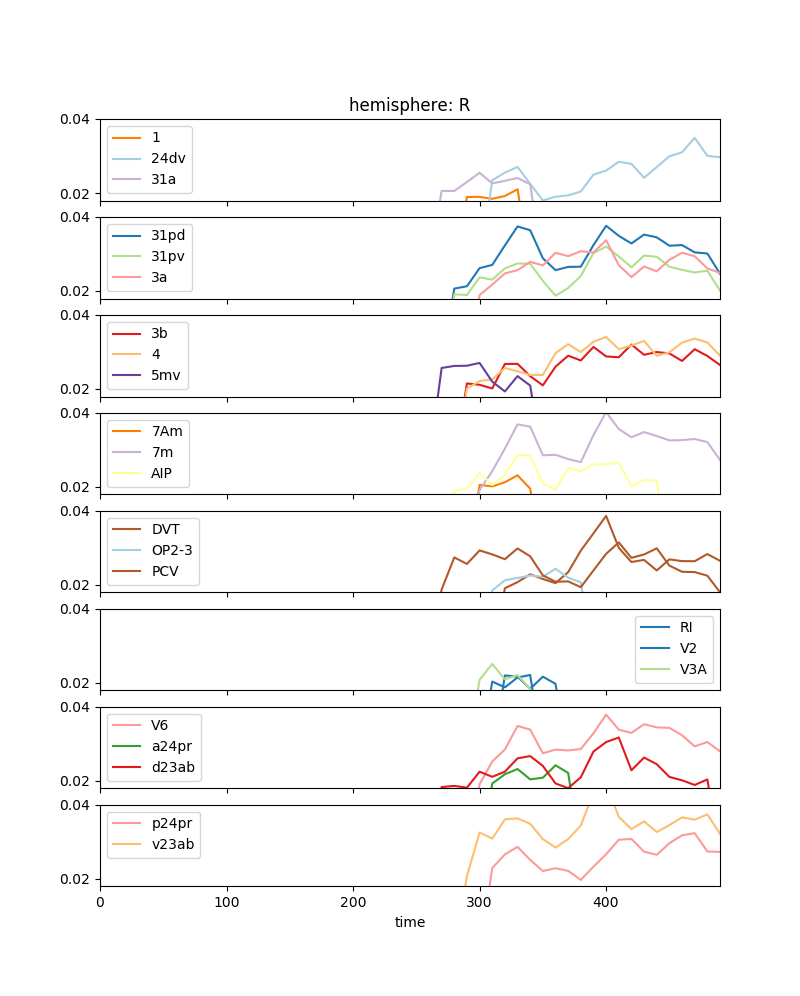

In [13]:
print(r_name)

time = 320

sv.show_timecourses(get_cluster_tcs(r_clusters[(time >= r_clusters.start_t) & (time <= r_clusters.end_t)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

## Investigate consistency

In [15]:
src_df.loc[('L_8Ad_ROI-lh', 350)]

mu_mean         0.024773
mu_std          0.006247
mu_t            3.965776
mu_testval      0.001365
mu_p_large      0.791000
sigma_mean      0.024500
sigma_std       0.005728
theta_mean      0.802082
theta_std       0.102769
lp_mean        61.247414
lp_std          1.619361
overlap        -1.858091
consistency     0.691500
Name: (L_8Ad_ROI-lh, 350), dtype: float64

In [42]:
for cl in r_clusters.itertuples():
    r_clusters.loc[cl.Index, 'mean_consistency'] = (
        src_df.loc[(cl.label, slice(cl.start_t, cl.end_t)), 'consistency'].mean())
    r_clusters.loc[cl.Index, 'max_consistency'] = (
        src_df.loc[(cl.label, slice(cl.start_t, cl.end_t)), 'consistency'].max())

r_clusters[r_clusters.max_consistency < 0.5].sort_values('start_t')

,label,start_t,end_t,log10p,pval_corrected,region,mean_consistency,max_consistency
cluster,,,,,,,,
585,R_PSL_ROI-rh,40,60,-4.788280,8.779328e-05,temporo-parieto-occipital junction,0.381000,0.4280
520,R_LIPv_ROI-rh,60,80,-4.692145,1.069446e-04,superior parietal cortex,0.170333,0.2370
638,R_TGv_ROI-rh,70,90,-4.307668,2.279281e-04,lateral temporal cortex,0.298333,0.3975
588,R_PeEc_ROI-rh,80,100,-5.107361,4.438894e-05,medial temporal cortex,0.401500,0.4820
723,R_s32_ROI-rh,140,150,-3.718194,8.371139e-04,anterior cingulate and medial prefrontal cortex,0.411500,0.4670
524,R_LO3_ROI-rh,170,190,-5.258906,3.185792e-05,MT+ complex and neighboring visual areas,0.126500,0.1975
424,R_7Am_ROI-rh,180,220,-7.538750,2.434695e-07,superior parietal cortex,0.344800,0.4310
158,L_LIPv_ROI-lh,210,230,-4.620899,1.227705e-04,superior parietal cortex,0.354167,0.4245
264,L_TF_ROI-lh,260,280,-4.411059,1.883832e-04,lateral temporal cortex,0.327000,0.3710
